version 1.0.3
#![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **Text Analysis and Entity Resolution**
####Entity resolution is a common, yet difficult problem in data cleaning and integration. This lab will demonstrate how we can use Apache Spark to apply powerful and scalable text analysis techniques and perform entity resolution across two datasets of commercial products.

#### Entity Resolution, or "[Record linkage][wiki]" is the term used by statisticians, epidemiologists, and historians, among others, to describe the process of joining records from one data source with another that describe the same entity. Our terms with the same meaning include, "entity disambiguation/linking", duplicate detection", "deduplication", "record matching", "(reference) reconciliation", "object identification", "data/information integration", and "conflation".
#### Entity Resolution (ER) refers to the task of finding records in a dataset that refer to the same entity across different data sources (e.g., data files, books, websites, databases). ER is necessary when joining datasets based on entities that may or may not share a common identifier (e.g., database key, URI, National identification number), as may be the case due to differences in record shape, storage location, and/or curator style or preference. A dataset that has undergone ER may be referred to as being cross-linked.
[wiki]: https://en.wikipedia.org/wiki/Record_linkage

### Code
#### This assignment can be completed using basic Python, pySpark Transformations and actions, and the plotting library matplotlib. Other libraries are not allowed.
### Files
#### Data files for this assignment are from the [metric-learning](https://code.google.com/p/metric-learning/) project and can be found at:
`cs100/lab3`
#### The directory contains the following files:
* **Google.csv**, the Google Products dataset
* **Amazon.csv**, the Amazon dataset
* **Google_small.csv**, 200 records sampled from the Google data
* **Amazon_small.csv**, 200 records sampled from the Amazon data
* **Amazon_Google_perfectMapping.csv**, the "gold standard" mapping
* **stopwords.txt**, a list of common English words
#### Besides the complete data files, there are "sample" data files for each dataset - we will use these for **Part 1**. In addition, there is a "gold standard" file that contains all of the true mappings between entities in the two datasets. Every row in the gold standard file has a pair of record IDs (one Google, one Amazon) that belong to two record that describe the same thing in the real world. We will use the gold standard to evaluate our algorithms.

### **Part 0: Preliminaries**
#### We read in each of the files and create an RDD consisting of lines.
#### For each of the data files ("Google.csv", "Amazon.csv", and the samples), we want to parse the IDs out of each record. The IDs are the first column of the file (they are URLs for Google, and alphanumeric strings for Amazon). Omitting the headers, we load these data files into pair RDDs where the *mapping ID* is the key, and the value is a string consisting of the name/title, description, and manufacturer from the record.
#### The file format of an Amazon line is:
   `"id","title","description","manufacturer","price"`
#### The file format of a Google line is:
   `"id","name","description","manufacturer","price"`

In [1]:
import re
DATAFILE_PATTERN = '^(.+),"(.+)",(.*),(.*),(.*)'

def removeQuotes(s):
    """ Remove quotation marks from an input string
    Args:
        s (str): input string that might have the quote "" characters
    Returns:
        str: a string without the quote characters
    """
    return ''.join(i for i in s if i!='"')


def parseDatafileLine(datafileLine):
    """ Parse a line of the data file using the specified regular expression pattern
    Args:
        datafileLine (str): input string that is a line from the data file
    Returns:
        str: a string parsed using the given regular expression and without the quote characters
    """
    match = re.search(DATAFILE_PATTERN, datafileLine)
    if match is None:
        print 'Invalid datafile line: %s' % datafileLine
        return (datafileLine, -1)
    elif match.group(1) == '"id"':
        print 'Header datafile line: %s' % datafileLine
        return (datafileLine, 0)
    else:
        product = '%s %s %s' % (match.group(2), match.group(3), match.group(4))
        return ((removeQuotes(match.group(1)), product), 1)

In [2]:
import sys
import os
from test_helper import Test

baseDir = os.path.join('data')
inputPath = os.path.join('cs100', 'lab3')

GOOGLE_PATH = 'Google.csv'
GOOGLE_SMALL_PATH = 'Google_small.csv'
AMAZON_PATH = 'Amazon.csv'
AMAZON_SMALL_PATH = 'Amazon_small.csv'
GOLD_STANDARD_PATH = 'Amazon_Google_perfectMapping.csv'
STOPWORDS_PATH = 'stopwords.txt'

def parseData(filename):
    """ Parse a data file
    Args:
        filename (str): input file name of the data file
    Returns:
        RDD: a RDD of parsed lines
    """
    return (sc
            .textFile(filename, 4, 0)
            .map(parseDatafileLine)
            .cache())

def loadData(path):
    """ Load a data file
    Args:
        path (str): input file name of the data file
    Returns:
        RDD: a RDD of parsed valid lines
    """
    filename = os.path.join(baseDir, inputPath, path)
    raw = parseData(filename).cache()
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    for line in failed.take(10):
        print '%s - Invalid datafile line: %s' % (path, line)
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    print '%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (path,
                                                                                        raw.count(),
                                                                                        valid.count(),
                                                                                        failed.count())
    assert failed.count() == 0
    assert raw.count() == (valid.count() + 1)
    return valid

googleSmall = loadData(GOOGLE_SMALL_PATH)
google = loadData(GOOGLE_PATH)
amazonSmall = loadData(AMAZON_SMALL_PATH)
amazon = loadData(AMAZON_PATH)

Google_small.csv - Read 201 lines, successfully parsed 200 lines, failed to parse 0 lines
Google.csv - Read 3227 lines, successfully parsed 3226 lines, failed to parse 0 lines
Amazon_small.csv - Read 201 lines, successfully parsed 200 lines, failed to parse 0 lines
Amazon.csv - Read 1364 lines, successfully parsed 1363 lines, failed to parse 0 lines


#### Let's examine the lines that were just loaded in the two subset (small) files - one from Google and one from Amazon

In [3]:
for line in googleSmall.take(3):
    print 'google: %s: %s\n' % (line[0], line[1])

for line in amazonSmall.take(3):
    print 'amazon: %s: %s\n' % (line[0], line[1])

google: http://www.google.com/base/feeds/snippets/11448761432933644608: spanish vocabulary builder "expand your vocabulary! contains fun lessons that both teach and entertain you'll quickly find yourself mastering new terms. includes games and more!" 

google: http://www.google.com/base/feeds/snippets/8175198959985911471: topics presents: museums of world "5 cd-rom set. step behind the velvet rope to examine some of the most treasured collections of antiquities art and inventions. includes the following the louvre - virtual visit 25 rooms in full screen interactive video detailed map of the louvre ..." 

google: http://www.google.com/base/feeds/snippets/18445827127704822533: sierrahome hse hallmark card studio special edition win 98 me 2000 xp "hallmark card studio special edition (win 98 me 2000 xp)" "sierrahome"

amazon: b000jz4hqo: clickart 950 000 - premier image pack (dvd-rom)  "broderbund"

amazon: b0006zf55o: ca international - arcserve lap/desktop oem 30pk "oem arcserve backup 

### **Part 1: ER as Text Similarity - Bags of Words**
#### A simple approach to entity resolution is to treat all records as strings and compute their similarity with a string distance function. In this part, we will build some components for performing bag-of-words text-analysis, and then use them to compute record similarity.
#### [Bag-of-words][bag-of-words] is a conceptually simple yet powerful approach to text analysis.
#### The idea is to treat strings, a.k.a. **documents**, as *unordered collections* of words, or **tokens**, i.e., as bags of words.
> #### **Note on terminology**: a "token" is the result of parsing the document down to the elements we consider "atomic" for the task at hand.  Tokens can be things like words, numbers, acronyms, or other exotica like word-roots or fixed-length character strings.
> #### Bag of words techniques all apply to any sort of token, so when we say "bag-of-words" we really mean "bag-of-tokens," strictly speaking.
#### Tokens become the atomic unit of text comparison. If we want to compare two documents, we count how many tokens they share in common. If we want to search for documents with keyword queries (this is what Google does), then we turn the keywords into tokens and find documents that contain them. The power of this approach is that it makes string comparisons insensitive to small differences that probably do not affect meaning much, for example, punctuation and word order.
[bag-of-words]: https://en.wikipedia.org/wiki/Bag-of-words_model

### **1(a) Tokenize a String**
#### Implement the function `simpleTokenize(string)` that takes a string and returns a list of non-empty tokens in the string. `simpleTokenize` should split strings using the provided regular expression. Since we want to make token-matching case insensitive, make sure all tokens are turned lower-case. Give an interpretation, in natural language, of what the regular expression, `split_regex`, matches.
#### If you need help with Regular Expressions, try the site [regex101](https://regex101.com/) where you can interactively explore the results of applying different regular expressions to strings. *Note that \W includes the "_" character*.  You should use [re.split()](https://docs.python.org/2/library/re.html#re.split) to perform the string split. Also, make sure you remove any empty tokens.

In [4]:
# TODO: Replace <FILL IN> with appropriate code
quickbrownfox = 'A quick brown fox jumps over the lazy dog.'
split_regex = r'\W+'

def simpleTokenize(string):
    """ A simple implementation of input string tokenization
    Args:
        string (str): input string
    Returns:
        list: a list of tokens
    """
    pattern = re.compile(split_regex)
    lst = pattern.split(string.lower())
    return filter(None, lst)

print simpleTokenize(quickbrownfox) # Should give ['a', 'quick', 'brown', ... ]

['a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


In [5]:
# TEST Tokenize a String (1a)
Test.assertEquals(simpleTokenize(quickbrownfox),
                  ['a','quick','brown','fox','jumps','over','the','lazy','dog'],
                  'simpleTokenize should handle sample text')
Test.assertEquals(simpleTokenize(' '), [], 'simpleTokenize should handle empty string')
Test.assertEquals(simpleTokenize('!!!!123A/456_B/789C.123A'), ['123a','456_b','789c','123a'],
                  'simpleTokenize should handle puntuations and lowercase result')
Test.assertEquals(simpleTokenize('fox fox'), ['fox', 'fox'],
                  'simpleTokenize should not remove duplicates')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


### **(1b) Removing stopwords**
#### *[Stopwords][stopwords]* are common (English) words that do not contribute much to the content or meaning of a document (e.g., "the", "a", "is", "to", etc.). Stopwords add noise to bag-of-words comparisons, so they are usually excluded.
#### Using the included file "stopwords.txt", implement `tokenize`, an improved tokenizer that does not emit stopwords.
[stopwords]: https://en.wikipedia.org/wiki/Stop_words

In [6]:
# TODO: Replace <FILL IN> with appropriate code
stopfile = os.path.join(baseDir, inputPath, STOPWORDS_PATH)
stopwords = set(sc.textFile(stopfile).collect())
print 'These are the stopwords: %s' % stopwords

def tokenize(string):
    """ An implementation of input string tokenization that excludes stopwords
    Args:
        string (str): input string
    Returns:
        list: a list of tokens without stopwords
    """
    pattern = re.compile(split_regex)
    lst = pattern.split(string.lower())
    return filter(lambda s: (s != '' and not s in stopwords), lst)

print tokenize(quickbrownfox) # Should give ['quick', 'brown', ... ]

These are the stopwords: set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'with', u'had', u'should', u'to', u'only', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'did', u'these', u't', u'each', u'where', u'because', u'doing', u'theirs', u'some', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'below', u'does', u'above', u'between', u'she', u'be', u'we', u'after', u'here', u'hers', u'by', u'on', u'about', u'of', u'against', u's', u'or', u'own', u'into', u'yourself', u'down', u'your', u'from', u'her', u'whom', u'there', u'been', u'few', u'too', u'themselves', u'was', u'until', u'more', u'himself', u'that', u'but', u'off', u'herself', u'than', u'those', u'he', u'me', u'myself', u'this', u'up', u'will', u'while', u'can', u'were', u'my', u'and', u'then', u'is', u'in', u'am', u'it', u'an', u'as', u'itself', u'at', u'have', u'further', u'their', u'if', u'again', u'no', u

In [7]:
# TEST Removing stopwords (1b)
Test.assertEquals(tokenize("Why a the?"), [], 'tokenize should remove all stopwords')
Test.assertEquals(tokenize("Being at the_?"), ['the_'], 'tokenize should handle non-stopwords')
Test.assertEquals(tokenize(quickbrownfox), ['quick','brown','fox','jumps','lazy','dog'],
                    'tokenize should handle sample text')

1 test passed.
1 test passed.
1 test passed.


### **(1c) Tokenizing the small datasets**
#### Now let's tokenize the two *small* datasets. For each ID in a dataset, `tokenize` the values, and then count the total number of tokens.
#### How many tokens, total, are there in the two datasets?

In [8]:
# TODO: Replace <FILL IN> with appropriate code
amazonRecToToken = amazonSmall.mapValues(tokenize)
googleRecToToken = googleSmall.mapValues(tokenize)

def countTokens(vendorRDD):
    """ Count and return the number of tokens
    Args:
        vendorRDD (RDD of (recordId, tokenizedValue)): Pair tuple of record ID to tokenized output
    Returns:
        count: count of all tokens
    """
    return vendorRDD.map(lambda t: len(t[1])).reduce(lambda a,b: a+b)

totalTokens = countTokens(amazonRecToToken) + countTokens(googleRecToToken)
print 'There are %s tokens in the combined datasets' % totalTokens

There are 22520 tokens in the combined datasets


In [9]:
# TEST Tokenizing the small datasets (1c)
Test.assertEquals(totalTokens, 22520, 'incorrect totalTokens')

1 test passed.


### **(1d) Amazon record with the most tokens**
#### Which Amazon record has the biggest number of tokens?
#### In other words, you want to sort the records and get the one with the largest count of tokens.

In [10]:
# TODO: Replace <FILL IN> with appropriate code
def findBiggestRecord(vendorRDD):
    """ Find and return the record with the largest number of tokens
    Args:
        vendorRDD (RDD of (recordId, tokens)): input Pair Tuple of record ID and tokens
    Returns:
        list: a list of 1 Pair Tuple of record ID and tokens
    """
    return vendorRDD.takeOrdered(1, lambda x: -len(x[1]))

biggestRecordAmazon = findBiggestRecord(amazonRecToToken)
#print biggestRecordAmazon[0]
print 'The Amazon record with ID "%s" has the most tokens (%s)' % (biggestRecordAmazon[0][0],
                                                                   len(biggestRecordAmazon[0][1]))

The Amazon record with ID "b000o24l3q" has the most tokens (1547)


In [11]:
# TEST Amazon record with the most tokens (1d)
Test.assertEquals(biggestRecordAmazon[0][0], 'b000o24l3q', 'incorrect biggestRecordAmazon')
Test.assertEquals(len(biggestRecordAmazon[0][1]), 1547, 'incorrect len for biggestRecordAmazon')

1 test passed.
1 test passed.


### **Part 2: ER as Text Similarity - Weighted Bag-of-Words using TF-IDF**
#### Bag-of-words comparisons are not very good when all tokens are treated the same: some tokens are more important than others. Weights give us a way to specify which tokens to favor. With weights, when we compare documents, instead of counting common tokens, we sum up the weights of common tokens. A good heuristic for assigning weights is called "Term-Frequency/Inverse-Document-Frequency," or [TF-IDF][tfidf] for short.
#### **TF**
#### TF rewards tokens that appear many times in the same document. It is computed as the frequency of a token in a document, that is, if document *d* contains 100 tokens and token *t* appears in *d* 5 times, then the TF weight of *t* in *d* is *5/100 = 1/20*. The intuition for TF is that if a word occurs often in a document, then it is more important to the meaning of the document.
#### **IDF**
#### IDF rewards tokens that are rare overall in a dataset. The intuition is that it is more significant if two documents share a rare word than a common one. IDF weight for a token, *t*, in a set of documents, *U*, is computed as follows:
* #### Let *N* be the total number of documents in *U*
* #### Find *n(t)*, the number of documents in *U* that contain *t*
* #### Then *IDF(t) = N/n(t)*.
#### Note that *n(t)/N* is the frequency of *t* in *U*, and *N/n(t)* is the inverse frequency.
> #### **Note on terminology**: Sometimes token weights depend on the document the token belongs to, that is, the same token may have a different weight when it's found in different documents.  We call these weights *local* weights.  TF is an example of a local weight, because it depends on the length of the source.  On the other hand, some token weights only depend on the token, and are the same everywhere that token is found.  We call these weights *global*, and IDF is one such weight.
#### **TF-IDF**
#### Finally, to bring it all together, the total TF-IDF weight for a token in a document is the product of its TF and IDF weights.
[tfidf]: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

### **(2a) Implement a TF function**
#### Implement `tf(tokens)` that takes a list of tokens and returns a Python [dictionary](https://docs.python.org/2/tutorial/datastructures.html#dictionaries) mapping tokens to TF weights.
#### The steps your function should perform are:
* #### Create an empty Python dictionary
* #### For each of the tokens in the input `tokens` list, count 1 for each occurance and add the token to the dictionary
* #### For each of the tokens in the dictionary, divide the token's count by the total number of tokens in the input `tokens` list

In [12]:
# TODO: Replace <FILL IN> with appropriate code
def tf(tokens):
    """ Compute TF
    Args:
        tokens (list of str): input list of tokens from tokenize
    Returns:
        dictionary: a dictionary of tokens to its TF values
    """
    cnt = len(tokens)
    d = dict()
    for token in tokens:
        d[token] = d.get(token, 0) + 1.0/cnt
    return d

print tf(tokenize(quickbrownfox)) # Should give { 'quick': 0.1666 ... }

{'brown': 0.16666666666666666, 'lazy': 0.16666666666666666, 'jumps': 0.16666666666666666, 'fox': 0.16666666666666666, 'dog': 0.16666666666666666, 'quick': 0.16666666666666666}


In [13]:
# TEST Implement a TF function (2a)
tf_test = tf(tokenize(quickbrownfox))
Test.assertEquals(tf_test, {'brown': 0.16666666666666666, 'lazy': 0.16666666666666666,
                             'jumps': 0.16666666666666666, 'fox': 0.16666666666666666,
                             'dog': 0.16666666666666666, 'quick': 0.16666666666666666},
                    'incorrect result for tf on sample text')
tf_test2 = tf(tokenize('one_ one_ two!'))
Test.assertEquals(tf_test2, {'one_': 0.6666666666666666, 'two': 0.3333333333333333},
                    'incorrect result for tf test')

1 test passed.
1 test passed.


### **(2b) Create a corpus**
#### Create a pair RDD called `corpusRDD`, consisting of a combination of the two small datasets, `amazonRecToToken` and `googleRecToToken`. Each element of the `corpusRDD` should be a pair consisting of a key from one of the small datasets (ID or URL) and the value is the associated value for that key from the small datasets.

In [14]:
# TODO: Replace <FILL IN> with appropriate code
corpusRDD = amazonRecToToken.union(googleRecToToken)

In [15]:
# TEST Create a corpus (2b)
Test.assertEquals(corpusRDD.count(), 400, 'incorrect corpusRDD.count()')

1 test passed.


### **(2c) Implement an IDFs function**
#### Implement `idfs` that assigns an IDF weight to every unique token in an RDD called `corpus`. The function should return an pair RDD where the `key` is the unique token and value is the IDF weight for the token.
#### Recall that the IDF weight for a token, *t*, in a set of documents, *U*, is computed as follows:
* #### Let *N* be the total number of documents in *U*.
* #### Find *n(t)*, the number of documents in *U* that contain *t*.
* #### Then *IDF(t) = N/n(t)*.
#### The steps your function should perform are:
* #### Calculate *N*. Think about how you can calculate *N* from the input RDD.
* #### Create an RDD (*not a pair RDD*) containing the unique tokens from each document in the input `corpus`. For each document, you should only include a token once, *even if it appears multiple times in that document.*
* #### For each of the unique tokens, count how many times it appears in the document and then compute the IDF for that token: *N/n(t)*
#### Use your `idfs` to compute the IDF weights for all tokens in `corpusRDD` (the combined small datasets).
#### How many unique tokens are there?

In [16]:
# TODO: Replace <FILL IN> with appropriate code
def idfs(corpus):
    """ Compute IDF
    Args:
        corpus (RDD): input corpus
    Returns:
        RDD: a RDD of (token, IDF value)
    """
    N = corpus.count()
    uniqueTokens = corpus.flatMap(lambda (k,v): set(v))
    tokenCountPairTuple = uniqueTokens.map(lambda t: (t, 1))
    tokenSumPairTuple = tokenCountPairTuple.reduceByKey(lambda a,b: a+b)
    return (tokenSumPairTuple.map(lambda (k,v): (k, float(N)/v)))

idfsSmall = idfs(amazonRecToToken.union(googleRecToToken))
uniqueTokenCount = idfsSmall.count()

print 'There are %s unique tokens in the small datasets.' % uniqueTokenCount

There are 4772 unique tokens in the small datasets.


In [17]:
# TEST Implement an IDFs function (2c)
Test.assertEquals(uniqueTokenCount, 4772, 'incorrect uniqueTokenCount')
tokenSmallestIdf = idfsSmall.takeOrdered(1, lambda s: s[1])[0]
Test.assertEquals(tokenSmallestIdf[0], 'software', 'incorrect smallest IDF token')
Test.assertTrue(abs(tokenSmallestIdf[1] - 4.25531914894) < 0.0000000001,
                'incorrect smallest IDF value')

1 test passed.
1 test passed.
1 test passed.


### **(2d) Tokens with the smallest IDF**
#### Print out the 11 tokens with the smallest IDF in the combined small dataset.

In [18]:
smallIDFTokens = idfsSmall.takeOrdered(11, lambda s: s[1])
print smallIDFTokens

[('software', 4.25531914893617), ('new', 6.896551724137931), ('features', 6.896551724137931), ('use', 7.017543859649122), ('complete', 7.2727272727272725), ('easy', 7.6923076923076925), ('create', 8.333333333333334), ('system', 8.333333333333334), ('cd', 8.333333333333334), ('1', 8.51063829787234), ('windows', 8.51063829787234)]


### **(2e) IDF Histogram**
#### Plot a histogram of IDF values.  Be sure to use appropriate scaling and bucketing for the data.
#### First plot the histogram using `matplotlib`

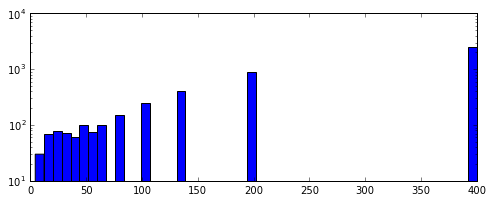

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

small_idf_values = idfsSmall.map(lambda s: s[1]).collect()
fig = plt.figure(figsize=(8,3))
plt.hist(small_idf_values, 50, log=True)
pass

### **(2f) Implement a TF-IDF function**
#### Use your `tf` function to implement a `tfidf(tokens, idfs)` function that takes a list of tokens from a document and a Python dictionary of IDF weights and returns a Python dictionary mapping individual tokens to total TF-IDF weights.
#### The steps your function should perform are:
* #### Calculate the token frequencies (TF) for `tokens`
* #### Create a Python dictionary where each token maps to the token's frequency times the token's IDF weight
#### Use your `tfidf` function to compute the weights of Amazon product record 'b000hkgj8k'. To do this, we need to extract the record for the token from the tokenized small Amazon dataset and we need to convert the IDFs for the small dataset into a Python dictionary. We can do the first part, by using a `filter()` transformation to extract the matching record and a `collect()` action to return the value to the driver. For the second part, we use the [`collectAsMap()` action](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap) to return the IDFs to the driver as a Python dictionary.

In [20]:
# TODO: Replace <FILL IN> with appropriate code
def tfidf(tokens, idfs):
    """ Compute TF-IDF
    Args:
        tokens (list of str): input list of tokens from tokenize
        idfs (dictionary): record to IDF value
    Returns:
        dictionary: a dictionary of records to TF-IDF values
    """
    tfs = tf(tokens)
    tfIdfDict = { token: tf * idfs[token] for (token, tf) in tfs.iteritems() }
    return tfIdfDict

recb000hkgj8k = amazonRecToToken.filter(lambda x: x[0] == 'b000hkgj8k').collect()[0][1]
idfsSmallWeights = idfsSmall.collectAsMap()
rec_b000hkgj8k_weights = tfidf(recb000hkgj8k, idfsSmallWeights)

print 'Amazon record "b000hkgj8k" has tokens and weights:\n%s' % rec_b000hkgj8k_weights

Amazon record "b000hkgj8k" has tokens and weights:
{'autocad': 33.33333333333333, 'autodesk': 8.333333333333332, 'courseware': 66.66666666666666, 'psg': 33.33333333333333, '2007': 3.5087719298245617, 'customizing': 16.666666666666664, 'interface': 3.0303030303030303}


In [21]:
# TEST Implement a TF-IDF function (2f)
Test.assertEquals(rec_b000hkgj8k_weights,
                   {'autocad': 33.33333333333333, 'autodesk': 8.333333333333332,
                    'courseware': 66.66666666666666, 'psg': 33.33333333333333,
                    '2007': 3.5087719298245617, 'customizing': 16.666666666666664,
                    'interface': 3.0303030303030303}, 'incorrect rec_b000hkgj8k_weights')

1 test passed.


### **Part 3: ER as Text Similarity - Cosine Similarity**
#### Now we are ready to do text comparisons in a formal way. The metric of string distance we will use is called **[cosine similarity][cosine]**. We will treat each document as a vector in some high dimensional space. Then, to compare two documents we compute the cosine of the angle between their two document vectors. This is *much* easier than it sounds.
#### The first question to answer is how do we represent documents as vectors? The answer is familiar: bag-of-words! We treat each unique token as a dimension, and treat token weights as magnitudes in their respective token dimensions. For example, suppose we use simple counts as weights, and we want to interpret the string "Hello, world!  Goodbye, world!" as a vector. Then in the "hello" and "goodbye" dimensions the vector has value 1, in the "world" dimension it has value 2, and it is zero in all other dimensions.
#### The next question is: given two vectors how do we find the cosine of the angle between them? Recall the formula for the dot product of two vectors:
#### $$ a \cdot b = \| a \| \| b \| \cos \theta $$
#### Here $ a \cdot b = \sum a_i b_i $ is the ordinary dot product of two vectors, and $ \|a\| = \sqrt{ \sum a_i^2 } $ is the norm of $ a $.
#### We can rearrange terms and solve for the cosine to find it is simply the normalized dot product of the vectors. With our vector model, the dot product and norm computations are simple functions of the bag-of-words document representations, so we now have a formal way to compute similarity:
#### $$ similarity = \cos \theta = \frac{a \cdot b}{\|a\| \|b\|} = \frac{\sum a_i b_i}{\sqrt{\sum a_i^2} \sqrt{\sum b_i^2}} $$
#### Setting aside the algebra, the geometric interpretation is more intuitive. The angle between two document vectors is small if they share many tokens in common, because they are pointing in roughly the same direction. For that case, the cosine of the angle will be large. Otherwise, if the angle is large (and they have few words in common), the cosine is small. Therefore, cosine similarity scales proportionally with our intuitive sense of similarity.
[cosine]: https://en.wikipedia.org/wiki/Cosine_similarity

### **(3a) Implement the components of a `cosineSimilarity` function**
#### Implement the components of a `cosineSimilarity` function.
#### Use the `tokenize` and `tfidf` functions, and the IDF weights from Part 2 for extracting tokens and assigning them weights.
#### The steps you should perform are:
* #### Define a function `dotprod` that takes two Python dictionaries and produces the dot product of them, where the dot product is defined as the sum of the product of values for tokens that appear in *both* dictionaries
* #### Define a function `norm` that returns the square root of the dot product of a dictionary and itself
* #### Define a function `cossim` that returns the dot product of two dictionaries divided by the norm of the first dictionary and then by the norm of the second dictionary

In [22]:
# TODO: Replace <FILL IN> with appropriate code
import math

def dotprod(a, b):
    """ Compute dot product
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
    Returns:
        dotProd: result of the dot product with the two input dictionaries
    """
    return sum([ v * b.get(k, 0) for (k,v) in a.iteritems() ])

def norm(a):
    """ Compute square root of the dot product
    Args:
        a (dictionary): a dictionary of record to value
    Returns:
        norm: a dictionary of tokens to its TF values
    """
    return math.sqrt(dotprod(a,a))

def cossim(a, b):
    """ Compute cosine similarity
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
    Returns:
        cossim: dot product of two dictionaries divided by the norm of the first dictionary and
                then by the norm of the second dictionary
    """
    return dotprod(a,b)/(norm(a) * norm(b))

testVec1 = {'foo': 2, 'bar': 3, 'baz': 5 }
testVec2 = {'foo': 1, 'bar': 0, 'baz': 20 }
dp = dotprod(testVec1, testVec2)
nm = norm(testVec1)
print dp, nm

102 6.16441400297


In [23]:
# TEST Implement the components of a cosineSimilarity function (3a)
Test.assertEquals(dp, 102, 'incorrect dp')
Test.assertTrue(abs(nm - 6.16441400297) < 0.0000001, 'incorrrect nm')

1 test passed.
1 test passed.


### **(3b) Implement a `cosineSimilarity` function**
#### Implement a `cosineSimilarity(string1, string2, idfsDictionary)` function that takes two strings and a dictionary of IDF weights, and computes their cosine similarity in the context of some global IDF weights.
#### The steps you should perform are:
* #### Apply your `tfidf` function to the tokenized first and second strings, using the dictionary of IDF weights
* #### Compute and return your `cossim` function applied to the results of the two `tfidf` functions

In [24]:
# TODO: Replace <FILL IN> with appropriate code
def cosineSimilarity(string1, string2, idfsDictionary):
    """ Compute cosine similarity between two strings
    Args:
        string1 (str): first string
        string2 (str): second string
        idfsDictionary (dictionary): a dictionary of IDF values
    Returns:
        cossim: cosine similarity value
    """
    w1 = tfidf(tokenize(string1), idfsDictionary)
    w2 = tfidf(tokenize(string2), idfsDictionary)
    return cossim(w1, w2)

cossimAdobe = cosineSimilarity('Adobe Photoshop',
                               'Adobe Illustrator',
                               idfsSmallWeights)

print cossimAdobe

0.0577243382163


In [25]:
# TEST Implement a cosineSimilarity function (3b)
Test.assertTrue(abs(cossimAdobe - 0.0577243382163) < 0.0000001, 'incorrect cossimAdobe')

1 test passed.


### **(3c) Perform Entity Resolution**
#### Now we can finally do some entity resolution!
#### For *every* product record in the small Google dataset, use your `cosineSimilarity` function to compute its similarity to every record in the small Amazon dataset.  Then, build a dictionary mapping `(Google URL, Amazon ID)` tuples to similarity scores between 0 and 1.
#### We'll do this computation two different ways, first we'll do it without a broadcast variable, and then we'll use a broadcast variable
#### The steps you should perform are:
* #### Create an RDD that is a combination of the small Google and small Amazon datasets that has as elements all pairs of elements (a, b) where a is in self and b is in other. The result will be an RDD of the form: `[ ((Google URL1, Google String1), (Amazon ID1, Amazon String1)), ((Google URL1, Google String1), (Amazon ID2, Amazon String2)), ((Google URL2, Google String2), (Amazon ID1, Amazon String1)), ... ]`
* #### Define a worker function that given an element from the combination RDD computes the cosineSimlarity for the two records in the element
* #### Apply the worker function to every element in the RDD
#### Now, compute the similarity between Amazon record `b000o24l3q` and Google record `http://www.google.com/base/feeds/snippets/17242822440574356561`.

In [26]:
# TODO: Replace <FILL IN> with appropriate code
crossSmall = (googleSmall
              .cartesian(amazonSmall)
              .cache())

def computeSimilarity(record):
    """ Compute similarity on a combination record
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallWeights)
    return (googleURL, amazonID, cs)

similarities = (crossSmall
                .map(computeSimilarity)
                .cache())

def similar(amazonID, googleURL):
    """ Return similarity value
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similarities
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogle = similar('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print 'Requested similarity is %s.' % similarityAmazonGoogle

Requested similarity is 0.000303171940451.


In [27]:
# TEST Perform Entity Resolution (3c)
Test.assertTrue(abs(similarityAmazonGoogle - 0.000303171940451) < 0.0000001,
                'incorrect similarityAmazonGoogle')

1 test passed.


### **(3d) Perform Entity Resolution with Broadcast Variables**
#### The solution in (3c) works well for small datasets, but it requires Spark to (automatically) send the `idfsSmallWeights` variable to all the workers. If we didn't `cache()` similarities, then it might have to be recreated if we run `similar()` multiple times. This would cause Spark to send `idfsSmallWeights` every time.
#### Instead, we can use a broadcast variable - we define the broadcast variable in the driver and then we can refer to it in each worker. Spark saves the broadcast variable at each worker, so it is only sent once.
#### The steps you should perform are:
* #### Define a `computeSimilarityBroadcast` function that given an element from the combination RDD computes the cosine simlarity for the two records in the element. This will be the same as the worker function `computeSimilarity` in (3c) except that it uses a broadcast variable.
* #### Apply the worker function to every element in the RDD
#### Again, compute the similarity between Amazon record `b000o24l3q` and Google record `http://www.google.com/base/feeds/snippets/17242822440574356561`.

In [28]:
# TODO: Replace <FILL IN> with appropriate code
def computeSimilarityBroadcast(record):
    """ Compute similarity on a combination record, using Broadcast variable
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallBroadcast.value)
    return (googleURL, amazonID, cs)

idfsSmallBroadcast = sc.broadcast(idfsSmallWeights)
similaritiesBroadcast = (crossSmall
                         .map(computeSimilarityBroadcast)
                         .cache())

def similarBroadcast(amazonID, googleURL):
    """ Return similarity value, computed using Broadcast variable
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similaritiesBroadcast
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogleBroadcast = similarBroadcast('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print 'Requested similarity is %s.' % similarityAmazonGoogleBroadcast

Requested similarity is 0.000303171940451.


In [29]:
# TEST Perform Entity Resolution with Broadcast Variables (3d)
from pyspark import Broadcast
Test.assertTrue(isinstance(idfsSmallBroadcast, Broadcast), 'incorrect idfsSmallBroadcast')
Test.assertEquals(len(idfsSmallBroadcast.value), 4772, 'incorrect idfsSmallBroadcast value')
Test.assertTrue(abs(similarityAmazonGoogleBroadcast - 0.000303171940451) < 0.0000001,
                'incorrect similarityAmazonGoogle')

1 test passed.
1 test passed.
1 test passed.


### **(3e) Perform a Gold Standard evaluation**
#### First, we'll load the "gold standard" data and use it to answer several questions. We read and parse the Gold Standard data, where the format of each line is "Amazon Product ID","Google URL". The resulting RDD has elements of the form ("AmazonID GoogleURL", 'gold')

In [30]:
GOLDFILE_PATTERN = '^(.+),(.+)'

# Parse each line of a data file useing the specified regular expression pattern
def parse_goldfile_line(goldfile_line):
    """ Parse a line from the 'golden standard' data file
    Args:
        goldfile_line: a line of data
    Returns:
        pair: ((key, 'gold', 1 if successful or else 0))
    """
    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    if match is None:
        print 'Invalid goldfile line: %s' % goldfile_line
        return (goldfile_line, -1)
    elif match.group(1) == '"idAmazon"':
        print 'Header datafile line: %s' % goldfile_line
        return (goldfile_line, 0)
    else:
        key = '%s %s' % (removeQuotes(match.group(1)), removeQuotes(match.group(2)))
        return ((key, 'gold'), 1)

goldfile = os.path.join(baseDir, inputPath, GOLD_STANDARD_PATH)
gsRaw = (sc
         .textFile(goldfile)
         .map(parse_goldfile_line)
         .cache())

gsFailed = (gsRaw
            .filter(lambda s: s[1] == -1)
            .map(lambda s: s[0]))
for line in gsFailed.take(10):
    print 'Invalid goldfile line: %s' % line

goldStandard = (gsRaw
                .filter(lambda s: s[1] == 1)
                .map(lambda s: s[0])
                .cache())

print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (gsRaw.count(),
                                                                                 goldStandard.count(),
                                                                                 gsFailed.count())
assert (gsFailed.count() == 0)
assert (gsRaw.count() == (goldStandard.count() + 1))

Read 1301 lines, successfully parsed 1300 lines, failed to parse 0 lines


### Using the "gold standard" data we can answer the following questions:
* #### How many true duplicate pairs are there in the small datasets?
* #### What is the average similarity score for true duplicates?
* #### What about for non-duplicates?
#### The steps you should perform are:
* #### Create a new `sims` RDD from the `similaritiesBroadcast` RDD, where each element consists of a pair of the form ("AmazonID GoogleURL", cosineSimilarityScore). An example entry from `sims` is: ('b000bi7uqs http://www.google.com/base/feeds/snippets/18403148885652932189', 0.40202896125621296)
* #### Combine the `sims` RDD with the `goldStandard` RDD by creating a new `trueDupsRDD` RDD that has the just the cosine similarity scores for those "AmazonID GoogleURL" pairs that appear in both the `sims` RDD and `goldStandard` RDD. Hint: you can do this using the join() transformation.
* #### Count the number of true duplicate pairs in the `trueDupsRDD` dataset
* #### Compute the average similarity score for true duplicates in the `trueDupsRDD` datasets. Remember to use `float` for calculation
* #### Create a new `nonDupsRDD` RDD that has the just the cosine similarity scores for those "AmazonID GoogleURL" pairs from the `similaritiesBroadcast` RDD that **do not** appear in both the *sims* RDD and gold standard RDD.
* #### Compute the average similarity score for non-duplicates in the last datasets. Remember to use `float` for calculation

In [31]:
# TODO: Replace <FILL IN> with appropriate code
sims = similaritiesBroadcast.map(lambda (g,a,cs): (a+' '+g,cs))

trueDupsRDD = (sims
               .join(goldStandard)
               .mapValues(lambda v: v[0])
               .cache())
trueDupsCount = trueDupsRDD.count()
avgSimDups = trueDupsRDD.values().sum() / trueDupsCount

nonDupsRDD = (sims
              .subtractByKey(trueDupsRDD))
avgSimNon = nonDupsRDD.values().sum() / nonDupsRDD.count()

print 'There are %s true duplicates.' % trueDupsCount
print 'The average similarity of true duplicates is %s.' % avgSimDups
print 'And for non duplicates, it is %s.' % avgSimNon

There are 146 true duplicates.
The average similarity of true duplicates is 0.264332573435.
And for non duplicates, it is 0.00123476304656.


In [32]:
# TEST Perform a Gold Standard evaluation (3e)
Test.assertEquals(trueDupsCount, 146, 'incorrect trueDupsCount')
Test.assertTrue(abs(avgSimDups - 0.264332573435) < 0.0000001, 'incorrect avgSimDups')
Test.assertTrue(abs(avgSimNon - 0.00123476304656) < 0.0000001, 'incorrect avgSimNon')

1 test passed.
1 test passed.
1 test passed.


### **Part 4: Scalable ER**
#### In the previous parts, we built a text similarity function and used it for small scale entity resolution.  Our implementation is limited by its quadratic run time complexity, and is not practical for even modestly sized datasets.  In this part, we will implement a more scalable algorithm and use it to do entity resolution on the full dataset.
### Inverted Indices
#### To improve our ER algorithm from the earlier parts, we should begin by analyzing its running time. In particular, the algorithm above is quadratic in two ways. First, we did a lot of redundant computation of tokens and weights, since each record was reprocessed every time it was compared. Second, we made quadratically many token comparisons between records.
#### The first source of quadratic overhead can be eliminated with precomputation and look-up tables, but the second source is a little more tricky. In the worst case, every token in every record in one dataset exists in every record in the other dataset, and therefore every token makes a non-zero contribution to the cosine similarity. In this case, token comparison is unavoidably quadratic.
#### But in reality most records have nothing (or very little) in common. Moreover, it is typical for a record in one dataset to have at most one duplicate record in the other dataset (this is the case assuming each dataset has been de-duplicated against itself). In this case, the output is linear in the size of the input and we can hope to achieve linear running time.
#### An [**inverted index**](https://en.wikipedia.org/wiki/Inverted_index) is a data structure that will allow us to avoid making quadratically many token comparisons.  It maps each token in the dataset to the list of documents that contain the token.  So, instead of comparing, record by record, each token to every other token to see if they match, we will use inverted indices to *look up* records that match on a particular token.
> #### **Note on terminology**: In text search, a *forward* index maps documents in a dataset to the tokens they contain.  An *inverted* index supports the inverse mapping.
> #### **Note**: For this section, use the complete Google and Amazon datasets, not the samples

### **(4a) Tokenize the full dataset**
#### Tokenize each of the two full datasets for Google and Amazon.

In [33]:
# TODO: Replace <FILL IN> with appropriate code
amazonFullRecToToken = amazon.mapValues(tokenize)
googleFullRecToToken = google.mapValues(tokenize)
print 'Amazon full dataset is %s products, Google full dataset is %s products' % (amazonFullRecToToken.count(),
                                                                                    googleFullRecToToken.count())

Amazon full dataset is 1363 products, Google full dataset is 3226 products


In [34]:
# TEST Tokenize the full dataset (4a)
Test.assertEquals(amazonFullRecToToken.count(), 1363, 'incorrect amazonFullRecToToken.count()')
Test.assertEquals(googleFullRecToToken.count(), 3226, 'incorrect googleFullRecToToken.count()')

1 test passed.
1 test passed.


### **(4b) Compute IDFs and TF-IDFs for the full datasets**
#### We will reuse your code from above to compute IDF weights for the complete combined datasets.
#### The steps you should perform are:
* #### Create a new `fullCorpusRDD` that contains the tokens from the full Amazon and Google datasets.
* #### Apply your `idfs` function to the `fullCorpusRDD`
* #### Create a broadcast variable containing a dictionary of the IDF weights for the full dataset.
* #### For each of the Amazon and Google full datasets, create weight RDDs that map IDs/URLs to TF-IDF weighted token vectors.

In [35]:
# TODO: Replace <FILL IN> with appropriate code
fullCorpusRDD = amazonFullRecToToken.union(googleFullRecToToken)
idfsFull = idfs(fullCorpusRDD)
idfsFullCount = idfsFull.count()
print 'There are %s unique tokens in the full datasets.' % idfsFullCount

# Recompute IDFs for full dataset
idfsFullWeights = idfsFull.collectAsMap()
idfsFullBroadcast = sc.broadcast(idfsFullWeights)

# Pre-compute TF-IDF weights.  Build mappings from record ID weight vector.
amazonWeightsRDD = amazonFullRecToToken.mapValues(lambda tokens: tfidf(tokens, idfsFullBroadcast.value))
googleWeightsRDD = googleFullRecToToken.mapValues(lambda tokens: tfidf(tokens, idfsFullBroadcast.value))
print 'There are %s Amazon weights and %s Google weights.' % (amazonWeightsRDD.count(),
                                                              googleWeightsRDD.count())

There are 17078 unique tokens in the full datasets.
There are 1363 Amazon weights and 3226 Google weights.


In [36]:
# TEST Compute IDFs and TF-IDFs for the full datasets (4b)
Test.assertEquals(idfsFullCount, 17078, 'incorrect idfsFullCount')
Test.assertEquals(amazonWeightsRDD.count(), 1363, 'incorrect amazonWeightsRDD.count()')
Test.assertEquals(googleWeightsRDD.count(), 3226, 'incorrect googleWeightsRDD.count()')

1 test passed.
1 test passed.
1 test passed.


### **(4c) Compute Norms for the weights from the full datasets**
#### We will reuse your code from above to compute norms of the IDF weights for the complete combined dataset.
#### The steps you should perform are:
* #### Create two collections, one for each of the full Amazon and Google datasets, where IDs/URLs map to the norm of the associated TF-IDF weighted token vectors.
* #### Convert each collection into a broadcast variable, containing a dictionary of the norm of IDF weights for the full dataset

In [37]:
# TODO: Replace <FILL IN> with appropriate code
amazonNorms = amazonWeightsRDD.mapValues(norm).collectAsMap()
amazonNormsBroadcast = sc.broadcast(amazonNorms)
googleNorms = googleWeightsRDD.mapValues(norm).collectAsMap()
googleNormsBroadcast = sc.broadcast(googleNorms)

In [38]:
# TEST Compute Norms for the weights from the full datasets (4c)
Test.assertTrue(isinstance(amazonNormsBroadcast, Broadcast), 'incorrect amazonNormsBroadcast')
Test.assertEquals(len(amazonNormsBroadcast.value), 1363, 'incorrect amazonNormsBroadcast.value')
Test.assertTrue(isinstance(googleNormsBroadcast, Broadcast), 'incorrect googleNormsBroadcast')
Test.assertEquals(len(googleNormsBroadcast.value), 3226, 'incorrect googleNormsBroadcast.value')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


### **(4d) Create inverted indicies from the full datasets**
#### Build inverted indices of both data sources.
#### The steps you should perform are:
* #### Create an invert function that given a pair of (ID/URL, TF-IDF weighted token vector), returns a list of pairs of (token, ID/URL). Recall that the TF-IDF weighted token vector is a Python dictionary with keys that are tokens and values that are weights.
* #### Use your invert function to convert the full Amazon and Google TF-IDF weighted token vector datasets into two RDDs where each element is a pair of a token and an ID/URL that contain that token. These are inverted indicies.

In [39]:
# TODO: Replace <FILL IN> with appropriate code
def invert(record):
    """ Invert (ID, tokens) to a list of (token, ID)
    Args:
        record: a pair, (ID, token vector)
    Returns:
        pairs: a list of pairs of token to ID
    """
    pairs = [ (token, record[0]) for token in record[1] ]
    return (pairs)

amazonInvPairsRDD = (amazonWeightsRDD
                    .flatMap(invert)
                    .cache())

googleInvPairsRDD = (googleWeightsRDD
                    .flatMap(invert)
                    .cache())

print 'There are %s Amazon inverted pairs and %s Google inverted pairs.' % (amazonInvPairsRDD.count(),
                                                                            googleInvPairsRDD.count())

There are 111387 Amazon inverted pairs and 77678 Google inverted pairs.


In [40]:
# TEST Create inverted indicies from the full datasets (4d)
invertedPair = invert((1, {'foo': 2}))
Test.assertEquals(invertedPair[0][1], 1, 'incorrect invert result')
Test.assertEquals(amazonInvPairsRDD.count(), 111387, 'incorrect amazonInvPairsRDD.count()')
Test.assertEquals(googleInvPairsRDD.count(), 77678, 'incorrect googleInvPairsRDD.count()')

1 test passed.
1 test passed.
1 test passed.


### **(4e) Identify common tokens from the full dataset**
#### We are now in position to efficiently perform ER on the full datasets. Implement the following algorithm to build an RDD that maps a pair of (ID, URL) to a list of tokens they share in common:
* #### Using the two inverted indicies (RDDs where each element is a pair of a token and an ID or URL that contains that token), create a new RDD that contains only tokens that appear in both datasets. This will yield an RDD of pairs of (token, iterable(ID, URL)).
* #### We need a mapping from (ID, URL) to token, so create a function that will swap the elements of the RDD you just created to create this new RDD consisting of ((ID, URL), token) pairs.
* #### Finally, create an RDD consisting of pairs mapping (ID, URL) to all the tokens the pair shares in common

In [41]:
# TODO: Replace <FILL IN> with appropriate code
def swap(record):
    """ Swap (token, (ID, URL)) to ((ID, URL), token)
    Args:
        record: a pair, (token, (ID, URL))
    Returns:
        pair: ((ID, URL), token)
    """
    token = record[0]
    keys = record[1]
    return (keys, token)

commonTokens = (amazonInvPairsRDD
                .join(googleInvPairsRDD)
                .map(swap)
                .groupByKey()
                .cache())

print 'Found %d common tokens' % commonTokens.count()

Found 2441100 common tokens


In [42]:
# TEST Identify common tokens from the full dataset (4e)
Test.assertEquals(commonTokens.count(), 2441100, 'incorrect commonTokens.count()')

1 test passed.


### **(4f) Identify common tokens from the full dataset**
#### Use the data structures from parts **(4a)** and **(4e)** to build a dictionary to map record pairs to cosine similarity scores.
#### The steps you should perform are:
* #### Create two broadcast dictionaries from the amazonWeights and googleWeights RDDs
* #### Create a `fastCosinesSimilarity` function that takes in a record consisting of the pair ((Amazon ID, Google URL), tokens list) and computes the sum for each of the tokens in the token list of the products of the Amazon weight for the token times the Google weight for the token. The sum should then be divided by the norm for the Google URL and then divided by the norm for the Amazon ID. The function should return this value in a pair with the key being the (Amazon ID, Google URL). *Make sure you use broadcast variables you created for both the weights and norms*
* #### Apply your `fastCosinesSimilarity` function to the common tokens from the full dataset

In [43]:
# TODO: Replace <FILL IN> with appropriate code
amazonWeightsBroadcast = sc.broadcast(amazonWeightsRDD.collectAsMap())
googleWeightsBroadcast = sc.broadcast(googleWeightsRDD.collectAsMap())

def fastCosineSimilarity(record):
    """ Compute Cosine Similarity using Broadcast variables
    Args:
        record: ((ID, URL), token)
    Returns:
        pair: ((ID, URL), cosine similarity value)
    """
    amazonRec = record[0][0]
    googleRec = record[0][1]
    tokens = record[1]
    s = sum([ amazonWeightsBroadcast.value[amazonRec][token] * googleWeightsBroadcast.value[googleRec][token] for token in tokens ])
    value = s / (amazonNormsBroadcast.value[amazonRec] * googleNormsBroadcast.value[googleRec])
    key = (amazonRec, googleRec)
    return (key, value)

similaritiesFullRDD = (commonTokens
                       .map(fastCosineSimilarity)
                       .cache())

print similaritiesFullRDD.count()

2441100


In [44]:
# TEST Identify common tokens from the full dataset (4f)
similarityTest = similaritiesFullRDD.filter(lambda ((aID, gURL), cs): aID == 'b00005lzly' and gURL == 'http://www.google.com/base/feeds/snippets/13823221823254120257').collect()
Test.assertEquals(len(similarityTest), 1, 'incorrect len(similarityTest)')
Test.assertTrue(abs(similarityTest[0][1] - 4.286548414e-06) < 0.000000000001, 'incorrect similarityTest fastCosineSimilarity')
Test.assertEquals(similaritiesFullRDD.count(), 2441100, 'incorrect similaritiesFullRDD.count()')

1 test passed.
1 test passed.
1 test passed.


### **Part 5: Analysis**
#### Now we have an authoritative list of record-pair similarities, but we need a way to use those similarities to decide if two records are duplicates or not. The simplest approach is to pick a **threshold**. Pairs whose similarity is above the threshold are declared duplicates, and pairs below the threshold are declared distinct.
#### To decide where to set the threshold we need to understand what kind of errors result at different levels. If we set the threshold too low, we get more **false positives**, that is, record-pairs we say are duplicates that in reality are not. If we set the threshold too high, we get more **false negatives**, that is, record-pairs that really are duplicates but that we miss.
#### ER algorithms are evaluated by the common metrics of information retrieval and search called **precision** and **recall**. Precision asks of all the record-pairs marked duplicates, what fraction are true duplicates? Recall asks of all the true duplicates in the data, what fraction did we successfully find? As with false positives and false negatives, there is a trade-off between precision and recall. A third metric, called **F-measure**, takes the harmonic mean of precision and recall to measure overall goodness in a single value:
#### $$ Fmeasure = 2 \frac{precision * recall}{precision + recall} $$
> #### **Note**: In this part, we use the "gold standard" mapping from the included file to look up true duplicates, and the results of Part 4.
> #### **Note**: In this part, you will not be writing any code. We've written all of the code for you. Run each cell and then answer the quiz questions on Studio.

### **(5a) Counting True Positives, False Positives, and False Negatives**
#### We need functions that count True Positives (true duplicates above the threshold), and False Positives and False Negatives:
* #### We start with creating the `simsFullRDD` from our `similaritiesFullRDD` that consists of a pair of ((Amazon ID, Google URL), simlarity score)
* #### From this RDD, we create an RDD consisting of only the similarity scores
* #### To look up the similarity scores for true duplicates, we perform a left outer join using the `goldStandard` RDD and `simsFullRDD` and extract the

In [45]:
# Create an RDD of ((Amazon ID, Google URL), similarity score)
simsFullRDD = similaritiesFullRDD.map(lambda x: ("%s %s" % (x[0][0], x[0][1]), x[1]))
assert (simsFullRDD.count() == 2441100)

# Create an RDD of just the similarity scores
simsFullValuesRDD = (simsFullRDD
                     .map(lambda x: x[1])
                     .cache())
assert (simsFullValuesRDD.count() == 2441100)

# Look up all similarity scores for true duplicates

# This helper function will return the similarity score for records that are in the gold standard and the simsFullRDD (True positives), and will return 0 for records that are in the gold standard but not in simsFullRDD (False Negatives).
def gs_value(record):
    if (record[1][1] is None):
        return 0
    else:
        return record[1][1]

# Join the gold standard and simsFullRDD, and then extract the similarities scores using the helper function
trueDupSimsRDD = (goldStandard
                  .leftOuterJoin(simsFullRDD)
                  .map(gs_value)
                  .cache())
print 'There are %s true duplicates.' % trueDupSimsRDD.count()
assert(trueDupSimsRDD.count() == 1300)

There are 1300 true duplicates.


#### The next step is to pick a threshold between 0 and 1 for the count of True Positives (true duplicates above the threshold). However, we would like to explore many different thresholds. To do this, we divide the space of thresholds into 100 bins, and take the following actions:
* #### We use Spark Accumulators to implement our counting function. We define a custom accumulator type, `VectorAccumulatorParam`, along with functions to initialize the accumulator's vector to zero, and to add two vectors. Note that we have to use the += operator because you can only add to an accumulator.
* #### We create a helper function to create a list with one entry (bit) set to a value and all others set to 0.
* #### We create 101 bins for the 100 threshold values between 0 and 1.
* #### Now, for each similarity score, we can compute the false positives. We do this by adding each similarity score to the appropriate bin of the vector. Then we remove true positives from the vector by using the gold standard data.
* #### We define functions for computing false positive and negative and true positives, for a given threshold.

In [46]:
from pyspark.accumulators import AccumulatorParam
class VectorAccumulatorParam(AccumulatorParam):
    # Initialize the VectorAccumulator to 0
    def zero(self, value):
        return [0] * len(value)

    # Add two VectorAccumulator variables
    def addInPlace(self, val1, val2):
        for i in xrange(len(val1)):
            val1[i] += val2[i]
        return val1

# Return a list with entry x set to value and all other entries set to 0
def set_bit(x, value, length):
    bits = []
    for y in xrange(length):
        if (x == y):
          bits.append(value)
        else:
          bits.append(0)
    return bits

# Pre-bin counts of false positives for different threshold ranges
BINS = 101
nthresholds = 100
def bin(similarity):
    return int(similarity * nthresholds)

# fpCounts[i] = number of entries (possible false positives) where bin(similarity) == i
zeros = [0] * BINS
fpCounts = sc.accumulator(zeros, VectorAccumulatorParam())

def add_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, 1, BINS)

simsFullValuesRDD.foreach(add_element)

# Remove true positives from FP counts
def sub_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, -1, BINS)

trueDupSimsRDD.foreach(sub_element)

def falsepos(threshold):
    fpList = fpCounts.value
    return sum([fpList[b] for b in range(0, BINS) if float(b) / nthresholds >= threshold])

def falseneg(threshold):
    return trueDupSimsRDD.filter(lambda x: x < threshold).count()

def truepos(threshold):
    return trueDupSimsRDD.count() - falsenegDict[threshold]

### **(5b) Precision, Recall, and F-measures**
#### We define functions so that we can compute the [Precision][precision-recall], [Recall][precision-recall], and [F-measure][f-measure] as a function of threshold value:
* #### Precision = true-positives / (true-positives + false-positives)
* #### Recall = true-positives / (true-positives + false-negatives)
* #### F-measure = 2 x Recall x Precision / (Recall + Precision)
[precision-recall]: https://en.wikipedia.org/wiki/Precision_and_recall
[f-measure]: https://en.wikipedia.org/wiki/Precision_and_recall#F-measure

In [47]:
# Precision = true-positives / (true-positives + false-positives)
# Recall = true-positives / (true-positives + false-negatives)
# F-measure = 2 x Recall x Precision / (Recall + Precision)

def precision(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falseposDict[threshold])

def recall(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falsenegDict[threshold])

def fmeasure(threshold):
    r = recall(threshold)
    p = precision(threshold)
    return 2 * r * p / (r + p)

### **(5c) Line Plots**
#### We can make line plots of precision, recall, and F-measure as a function of threshold value, for thresholds between 0.0 and 1.0.  You can change `nthresholds` (above in part **(5a)**) to change the threshold values to plot.

0.000532546802671 0.00106452669505


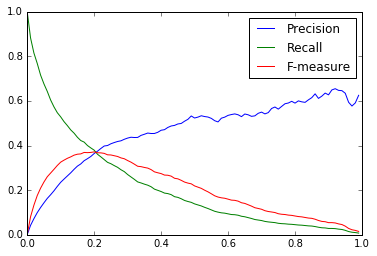

In [48]:
thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]
falseposDict = dict([(t, falsepos(t)) for t in thresholds])
falsenegDict = dict([(t, falseneg(t)) for t in thresholds])
trueposDict = dict([(t, truepos(t)) for t in thresholds])

precisions = [precision(t) for t in thresholds]
recalls = [recall(t) for t in thresholds]
fmeasures = [fmeasure(t) for t in thresholds]

print precisions[0], fmeasures[0]
assert (abs(precisions[0] - 0.000532546802671) < 0.0000001)
assert (abs(fmeasures[0] - 0.00106452669505) < 0.0000001)


fig = plt.figure()
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fmeasures)
plt.legend(['Precision', 'Recall', 'F-measure'])
pass

### Discussion
#### State-of-the-art tools can get an F-measure of about 60% on this dataset. In this lab exercise, our best F-measure is closer to 40%. Look at some examples of errors (both False Positives and False Negatives) and think about what went wrong.
### There are several ways we might improve our simple classifier, including:
#### * Using additional attributes
#### * Performing better featurization of our textual data (e.g., stemming, n-grams, etc.)
#### * Using different similarity functions